# Data Cleaning

## Objectives
Our objectives for this notebook are as following:

- Prepare the data sets for further analysis.
- Load and inspect the data from Data collection 
- Correlation and PPS study.
- Data Cleaning.

## Inputs
- outputs/datasets/collection/HousePrice.csv

## Outputs
- outputs/datasets/cleaned/train_set.csv
- outputs/datasets/cleaned/test_set.csv
- outputs/datasets/cleaned/clean_house_price_records.csv
- outputs/datasets/cleaned/clean_refurbished_houses.csv
  
## Notes

- This projects relays on the guidelines provided in the walk through projects, and the lessons provided along the course provided by code institute (especially in the Predictive Analysis)

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [17]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Heritage-Housing'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [18]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [19]:
current_dir = os.getcwd()
current_dir

'/workspaces'

# Load Data

In [20]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas_profiling import ProfileReport
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from sklearn.pipeline import Pipeline

In [21]:

df = pd.read_csv(f"/workspaces/Heritage-Housing/outputs/datasets/collection/HousePrices.csv")
print(df.shape)

(1460, 22)


## Data Exploration

To begin, we'll explore the dataset by examining variable types, distributions, and any missing values or levels. We'll also assess the potential contribution of each variable in relation to the first business requirement.

Our first step is to identify the variables that contain missing values.

In [22]:
vars_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea']

Create a Pandas Profiling report that includes only the var_missing_data variable for analysis.

In [23]:
from ydata_profiling import ProfileReport
if vars_missing_data:
    profile = ProfileReport(df=df[vars_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Analysis

The following code cell is sourced from the Code Institute's Churnometer walkthrough project and generates two correlation heatmaps along with Predictive Power Score (PPS) charts.

Specifically:

- Correlation heatmaps help identify which features have strong linear relationships with each other and with the target variable (e.g. sale price).

- PPS (Predictive Power Score) charts go a step further by detecting non-linear and asymmetric relationships, revealing variables that are useful for prediction even if their correlation is weak or non-existent.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate both the correlation matrix and the Predictive Power Score (PPS) to assess relationships between variables

In [42]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.064  0.111  0.0  0.0  0.0  0.088  0.702




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



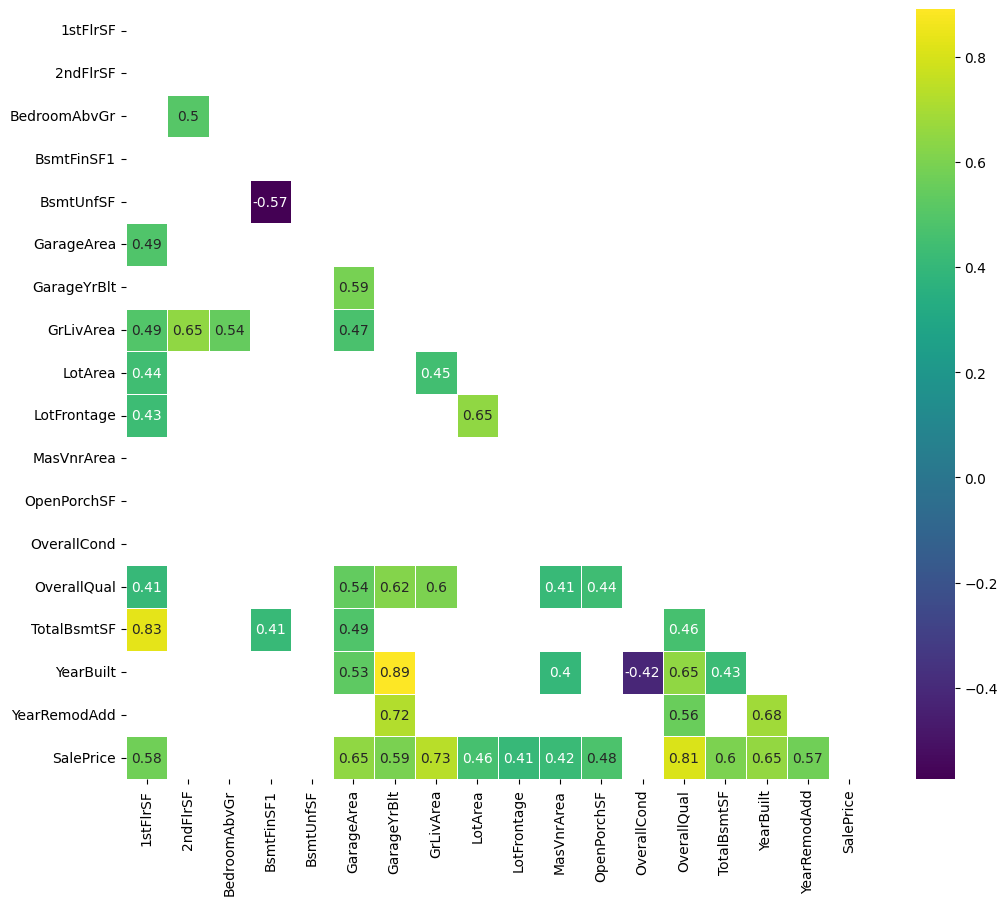



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



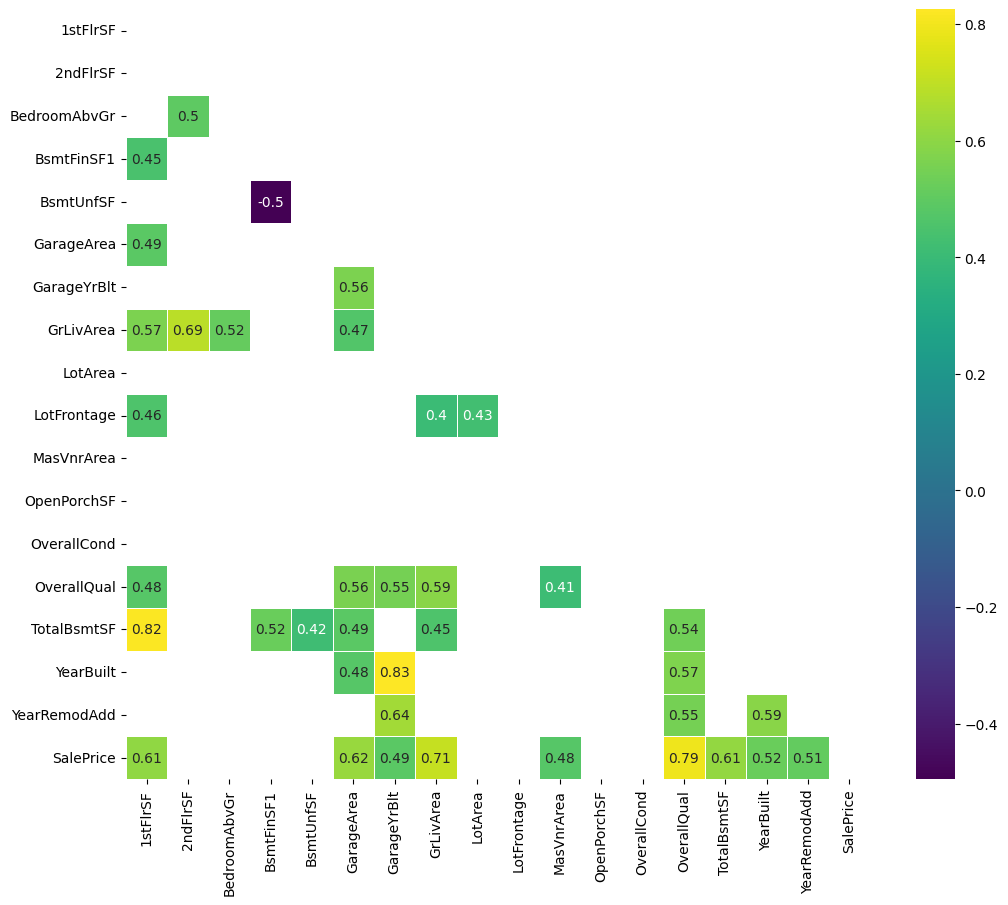



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



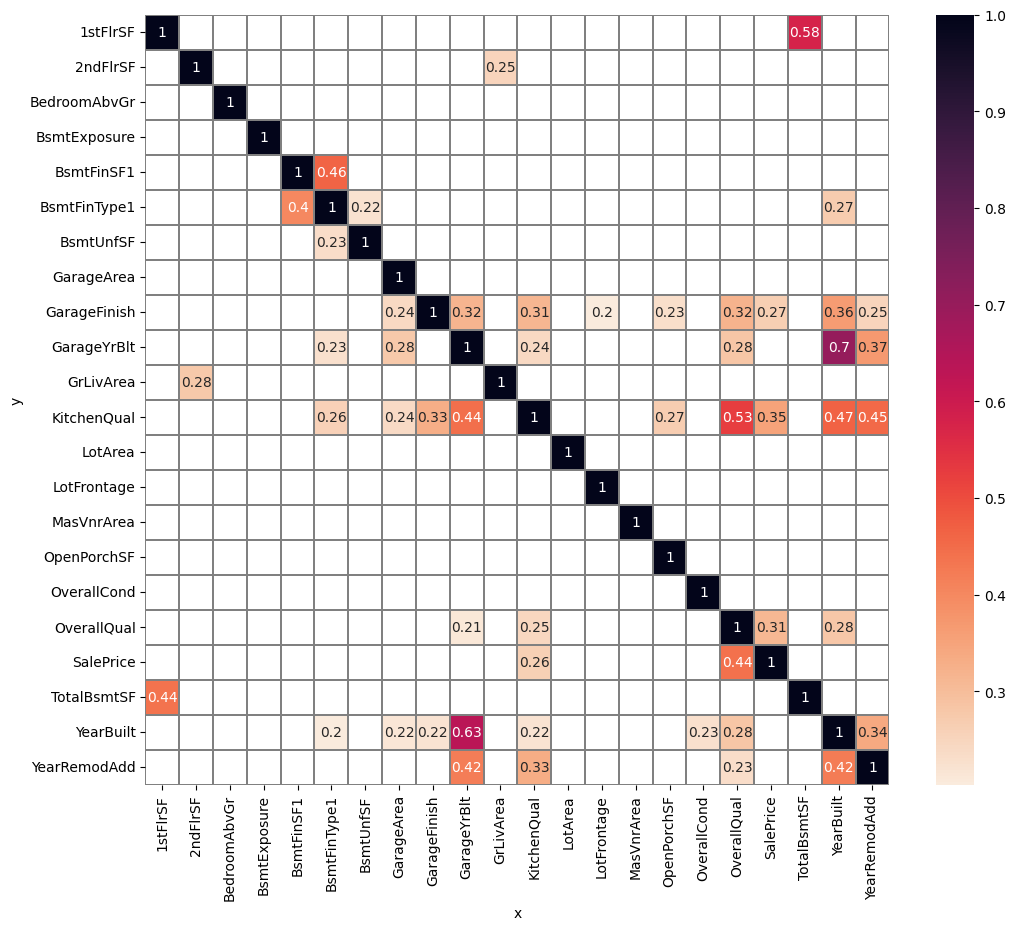

In [43]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)